In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import config, convert2yolov1
from src.util import video2images, get_video_folder_paths, seleccionar_imagen, merge_datasets 
#from src.model import autolabel_images, predict_and_visualice
from src.dataset_processing import run_processing_dataset
import os
import json
import supervision as sv
import cv2
from src.data_augmentation import augment_dataset

## Pruebas de ontologia

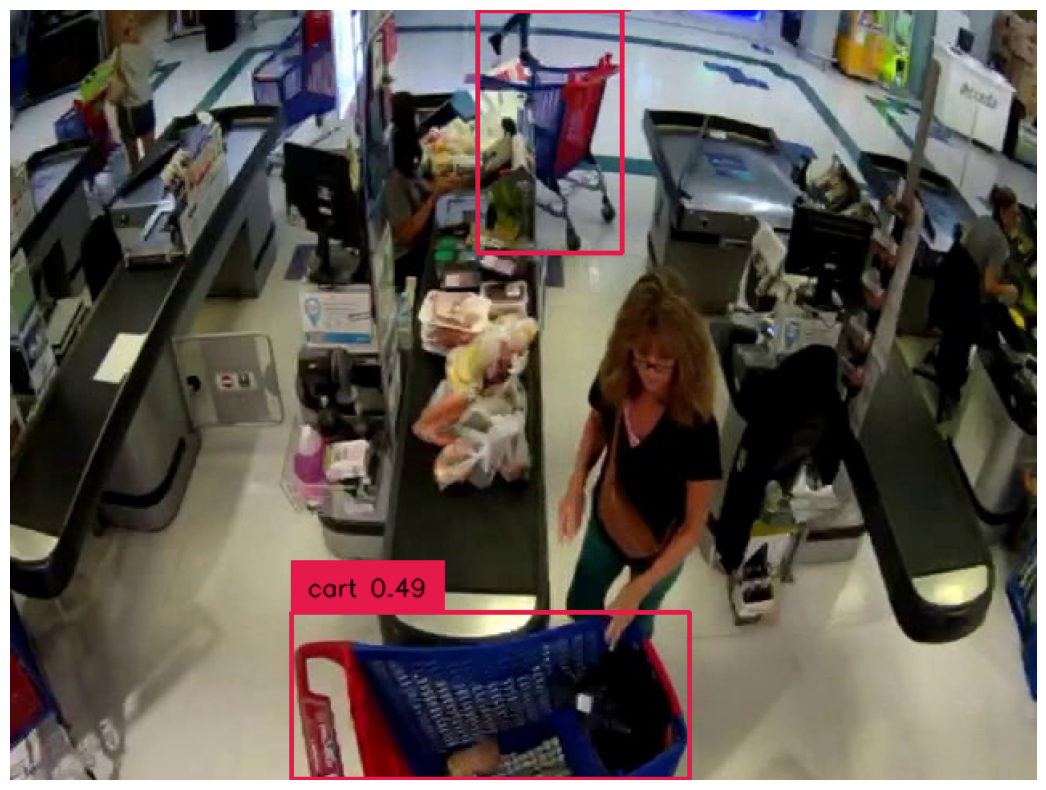

In [17]:
from src.model import predict_and_visualice
from src.util import seleccionar_imagen
image_path=seleccionar_imagen()
predict_and_visualice(image_path, {"Shopping cart": "cart"}, box_threshold=0.35, text_threshold=0.25)

## Run pipeline autolabeling

In [ ]:
import autolabeling
from src.util import get_video_folder_paths
from src import config
import json
import os
from tqdm import tqdm

video_paths = get_video_folder_paths(config.VIDEO_DIR_PATH)
for video_path in tqdm(video_paths):
    autolabeling.mypipeline(
        video_path=video_path,
        image_dir_path=config.IMAGE_DIR_PATH,
        frame_rate=40,
        ontology=json.load(open(os.path.join(video_paths[0], "ontology.json"))),
        output_images=config.DATASET_DIR_PATH,
        extension=".jpg",
        box_threshold =0.35,
        text_threshold = 0.25,
        num_datasets=1,
        height = None, 
        width = None,
        use_yolo = True, # Si queremos usar un modleo yolo en lugar de grounded dino
        not_val=False, # Si queremos un set de validacion colocar False
        val_ratio= 0.2, # 20% para validación
        model_path = "trained_models/yolov8m_640x480_cf_9cam_v34.pt", #path al modelo yolo
        confidence=0.4,
        iou=0.7,
        imgsz=640,
    ) 

In [22]:
# Si solo tienes una carpeta de imágenes
from src.model import autolabel_images
autolabel_images(
            input_folder="./images/Train_linea_de_caja_640x480",
            ontology=json.load(open(os.path.join("./images/Train_linea_de_caja_640x480", "ontology.json"))),
            box_threshold=0.35,
            text_threshold=0.25,
            output_folder="./dataset",
            extension=".jpg",
            num_datasets=1,
            val=False,
            val_ratio=0.2,
        )

Labeling ./images/Train_linea_de_caja_640x480\camera65_640x480_20240311_105646-00002.jpg for dataset 1: 100%|██████████| 3/3 [01:16<00:00, 25.56s/it]


Labeled dataset 1 created - ready for distillation.


# Run pipeline autotracking
Autotracking usa un modelo yolo prentrenado. Está pensado para un dataset yolo sin set de validación

In [ ]:
import autotracking
from tqdm import tqdm
from src.dataset_processing import run_processing_dataset
# obtener los path de las subcarpetas dentro de /videos
video_paths = get_video_folder_paths(config.VIDEO_DIR_PATH)

# Procesar cada carpeta de video independientemente y generar un dataset yolo para cada una
for video_path in tqdm(video_paths):
            autotracking.mypipeline_track(
                video_path,
                image_dir_path=config.IMAGE_DIR_PATH,
                frame_rate=20,
                output_images=config.DATASET_DIR_PATH,
                extension=".jpg",
                height = None, # None 480
                width = None, # None 640
                model_path = "trained_models/yolov8_raffin_person_all_camHD_v04.pt",
                confidence=0.4,
                iou=0.7,
                imgsz=1280, #1280 640
            )
            



In [ ]:
# Procesar Merged_Dataset/train para eliminar errores de anotación
contenido = os.listdir(config.DATASET_DIR_PATH)
print("Contenido \n", contenido)
for data_p in contenido:
        output_path = os.path.join(config.DATASET_DIR_PATH, data_p)
        run_processing_dataset(
            os.path.join(output_path, "train", "images"),
            os.path.join(output_path, "train", "labels"),
            max_size=0.8,
            min_size=0.1,
            iou_threshold=0.7,
            remove_empty=False,
            remove_large=False,
            remove_small=False,
            remove_overlapping=False,
            remove_multiple=False,
        )

In [ ]:
# si solo tienes carpetas de imagenes
from src.model import label_multiple_yolov8

label_multiple_yolov8(
    model_path="trained_models/yolov8m_640x480_cf_9cam_v34.pt",
    input_folder="images/vicente_lopez_fondo",
    output_folder="dataset",
    confidence=0.4,
    iou=0.7,
    imgsz=640,
    tracking=False, # Usar True si no queremos set de validación
    val_ratio=0.3
    )

# Hacer merged de datasets

In [26]:
# Unir datasets
# crear el path a la carpeta de merged dataset dentro de dataset
output_path = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset")
    # obtener el nombre de cada dataset individual dentro de dataset
folders = os.listdir(config.DATASET_DIR_PATH)
    # Lista de paths de cada dataset individual
dataset_paths = [os.path.join(config.DATASET_DIR_PATH, folder) for folder in folders]
    # Hacer el merge
merge_datasets(dataset_paths, output_path, val=False) # val = False para autotracking

INFO:root:Merging datasets...
100%|██████████| 9/9 [00:00<00:00, 35.57it/s]
INFO:root:Merged datasets created at d:\Alexander\Go2Future\Autolabel_roboflow\dataset\Merged_Dataset


['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']
['person']


# Remover etiquetas incorrectas

In [9]:
# Procesar Merged_Dataset/train para eliminar errores de anotación
output_path = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset")
run_processing_dataset(
        os.path.join(output_path, "train", "images"),
        os.path.join(output_path, "train", "labels"),
        min_size=0.1,
        max_size=0.8,
        iou_threshold=0.7,
        remove_empty= True,
        remove_large= False,
        remove_small= False,
        remove_overlapping= False,
        remove_multiple= False,
    )



removed empty
removed empty


In [ ]:
# Procesar Merged_Dataset/valid para eliminar errores de anotación
run_processing_dataset(
        os.path.join(output_path, "valid", "images"),
        os.path.join(output_path, "valid", "labels"),
        min_size=0.1,
        max_size=0.8,
        iou_threshold=0.7,
        remove_empty= True,
        remove_large= False,
        remove_small= False,
        remove_overlapping= False,
        remove_multiple= False,
    )


# Hacer data augmentation

In [ ]:
dataset_path=os.path.join(config.DATASET_DIR_PATH, "Productos_en_mano_HD_v02_YOLOV8")
augmented_dataset_path=os.path.join(config.DATASET_DIR_PATH, "Productos_en_mano_HD_v02_YOLOV8_aug")
# creating aumented datased directory
if not os.path.exists(augmented_dataset_path):
    os.makedirs(augmented_dataset_path)

augment_dataset(dataset_path, augmented_dataset_path, just_rezize=False, augmented_for=2, height=720, width=1280, val=True)

# Convertir a formato YOLOv1 de CVAT

In [6]:
from src import config, convert2yolov1
import os
# Convertir un solo dataset dentro de DATASET_DIR_PATH
dataset_path=os.path.join(config.DATASET_DIR_PATH, "T04")
convert2yolov1.convert_to_yolov1_format(dataset_path, with_val=False) 

In [ ]:
# Convertir todos los datasets dentro de un directorio a formato YOLOv1
# Directorio que contiene todos los datasets
dataset_dir_path = config.DATASET_DIR_PATH

# Iterar a través de los subdirectorios en DATASET_DIR_PATH
for dataset_name in os.listdir(dataset_dir_path):
    dataset_path = os.path.join(dataset_dir_path, dataset_name)
    
    # Verificar si el elemento en DATASET_DIR_PATH es un directorio
    if os.path.isdir(dataset_path):
        print(f"Procesando el dataset: {dataset_name}")
        convert2yolov1.convert_to_yolov1_format(dataset_path, with_val=False)

print("Proceso de conversión completado para todos los datasets.")

# Convertir anotaciones de Yolov1 CVAT a Yolov8 

In [3]:
# crear un directorio dentro de config.DATASET_DIR_PATH
#yolo8_out =os.path.join(config.DATASET_DIR_PATH,"CF_Vicente_Lopez_9cam_1280x720_v1")
yolo8_out = config.DATASET_DIR_PATH
os.makedirs(yolo8_out, exist_ok=True)

convert2yolov1.convert_to_yolov8_format(os.path.join(config.DATASET_DIR_PATH,"Productos_en_mano_HD_02.zip"),yolo8_out)

# Visualizar anotaciones en formato YOLO

In [7]:
import visualizar_anotaciones

# Permitir al usuario seleccionar el directorio
directorio_seleccionado = visualizar_anotaciones.seleccionar_directorio()
if not directorio_seleccionado:
        print("No se ha seleccionado un directorio. Saliendo.")
        exit()

    # Obtener los paths de las carpetas "images" y "labels"
directorio_imagenes = os.path.join(directorio_seleccionado, "images")
directorio_labels = os.path.join(directorio_seleccionado, "labels")

# Verificar la existencia de las carpetas "images" y "labels"
if not os.path.exists(directorio_imagenes) or not os.path.exists(directorio_labels):
        print(
            "No se encontraron las carpetas 'images' y 'labels'. Asegúrate de que la estructura sea correcta."
        )
        exit()

# Ejecutar la función con los directorios proporcionados
visualizar_anotaciones.mostrar_imagenes_y_anotaciones(directorio_imagenes, directorio_labels)

Presiona 'q' para salir.


# Procesar dataset de ReID

In [1]:
# Crear Formato Market1501 a partir de CVAT for images 1.1
from src import crear_market1501
import os

xml_dir = "./dataset/Pilar_11cam_ReID"  # "D:\Alexander\Go2Future\Autolabel_roboflow\dataset\cvat_3cam_3id"
xml_file = "annotations.xml"
xml_path = os.path.join(xml_dir, xml_file)
output_dir = "default"
print(xml_path)

# obtener el nombre de la carpeta de xml_dir
output_folder = os.path.basename(xml_dir)

if output_dir == "default":
    output_dir = os.path.join(xml_dir, f"{output_folder}_market_format")
else:
    output_dir = os.path.join(output_dir, f"{output_folder}_market_format")

cvat_annotations = crear_market1501.parse_cvat_annotations(xml_path)
crear_market1501.process_cvat_annotations(
    cvat_annotations,
    output_dir,
    path_to_images=os.path.join(xml_dir, "images", "train"),
)

./dataset/Pilar_11cam_ReID/annotations.xml


In [ ]:
# Conformar las carpetas train, test y query
from src import split_train_test_query

dataset_path = "./dataset/Pilar_11cam_ReID/Pilar_11cam_ReID_market_format"  # Reemplazar con la ruta de tu dataset
output_path = "./dataset/Pilar_11cam_ReID/Pilar_11cam_ReID"  # Reemplazar con la ruta deseada para el nuevo dataset

split_train_test_query.split_dataset(dataset_path, output_path, split_ratio=0.5)

## Aumentar Dataset de ReID

In [ ]:
# Ejemplo de uso
from src.data_augmentation import augment_images_reid

input_directory = "dataset/Pilar_11cam_ReID\Pilar_11cam_ReID_market_format/0002" 
output_directory = "dataset/Pilar_11cam_ReID/query_augmented"
num_augmentations = 3  # Cambia este valor al número deseado de aumentaciones por imagen

augment_images_reid(input_directory, output_directory, num_augmentations=3)

## Estadisticas de colores y tamaño de las imagenes dentro del dataset de ReID

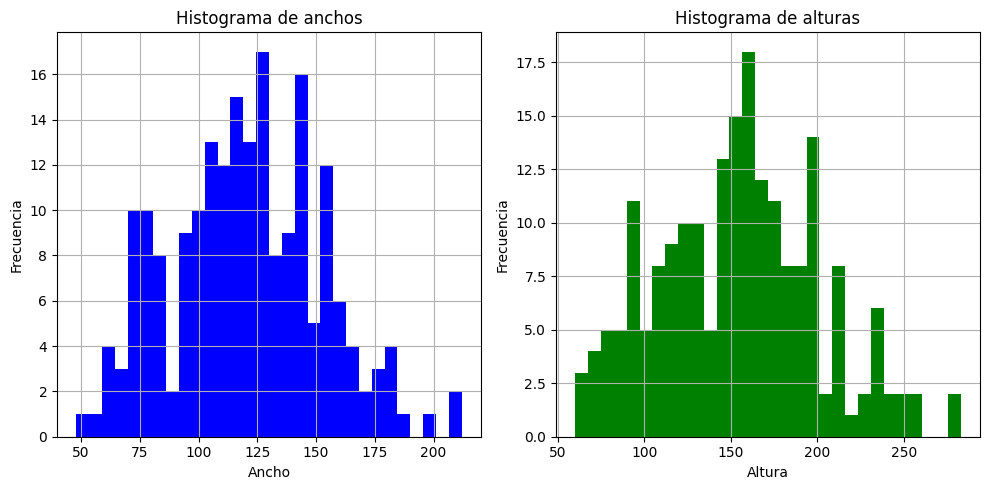

Estadísticas de los canales RGB:
Canal Rojo - Min: 0 Max: 255
Canal Rojo - Media: 0.37825940656431906 Desviación estándar: 0.24183209454386054
Canal Verde - Media: 0.38317903565422085 Desviación estándar: 0.23919170666078535
Canal Azul - Media: 0.38282038073606833 Desviación estándar: 0.2382830307578967

Valor mínimo del ancho: 48
Valor máximo del ancho: 212
Valor medio del ancho: 120.2139303482587
Valor mediana del ancho: 120.0
Valor std del ancho: 32.225557747144606
Bin mas repetido ancho: 124.53333333333333
Valor mínimo del alto: 60
Valor máximo del alto: 283
Valor medio del alto: 154.07960199004975
Valor mediana del alto: 156.0
Valor std del alto: 45.87928820730278
Bin mas repetido alto: 156.63333333333333


In [1]:
from src.util import calcular_estadisticas_imagenes
Metricas=calcular_estadisticas_imagenes("./dataset/Pilar_11cam_ReID/Pilar_11cam_ReID/query")